# Fifth exercice: Non-Cartesian radial under-sampling

In this notebook, you can play with the design parameters to regenerate different radial in-out patterns (so, we draw radial spokes over a rotating angle of $\pi$). You can play with the number of shots by changing the under-sampling factor.

- Authors: Philippe Ciuciu (philippe.ciuciu@cea.fr)
- Date: 04/02/2019
- Target: [ISBI'19 tutorial](https://biomedicalimaging.org/2019/tutorials/) on **Recent  advances in acquisition and reconstruction for Compressed Sensing MRI**
- **Revision**: 01/06/2021 for ATSI MSc hands-on session at Paris-Saclay University.

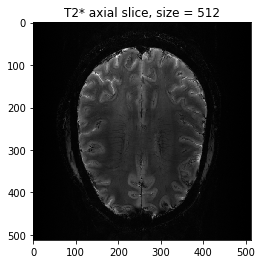

In [23]:
#DISPLAY BRAIN PHANTOM
%matplotlib inline

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib.pyplot as plt
import sys
from mri.operators import NonCartesianFFT
from mri.operators.utils import convert_locations_to_mask, \
    gridded_inverse_fourier_transform_nd
from pysap.data import get_sample_data


from skimage import data, img_as_float, io, filters
from modopt.math.metrics import ssim

#get current working dir

#cwd = os.getcwd()
#dirimg_2d = op.join(cwd,"..","data")
#FOV = 0.2 #field of view parameter in m (ie real FOV = 20 x20 cm^2)
#pixelSize = FOV/img_size
#load data file corresponding to the target resolution
#filename = "BrainPhantom" + str(img_size) + ".png"
#mri_filename = op.join(dirimg_2d, filename)
#mri_img = io.imread(mri_filename, as_gray=True)

mri_img = get_sample_data('2d-mri')
img_size = mri_img.shape[0]

plt.figure()
plt.title("T2* axial slice, size = {}".format(img_size))
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.show()

number of shots: 64
number of samples per shot: 512


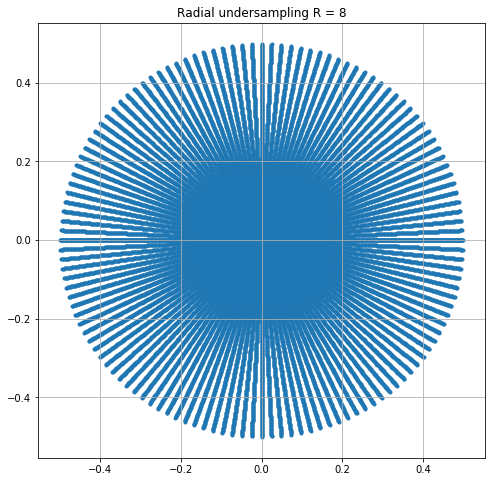

In [28]:
# set up the first shot
rfactor = 8
nb_shots = math.ceil(img_size/rfactor)
print("number of shots: {}".format(nb_shots))

# vectorize the nb of shots        
vec_shots = np.arange(0,nb_shots + 1)

# define the regularly spaced samples on a single shot
nsamples = (np.arange(0,img_size) - img_size//2)/(img_size)
print("number of samples per shot: {}".format(np.size(nsamples)))

shot_c = np.array(nsamples, dtype = np.complex_)
shots = np.array([], dtype = np.complex_)    
# acculumate shots after rotating the initial one by the right angular increment        
for k in vec_shots:
    shots = np.append(shots, shot_c * np.exp(2 * np.pi * 1j * k/(2*nb_shots)))

kspace_loc = np.zeros((len(shots),2))
#assign real and imaginary parts of complex-valued k-space trajectories to k-space locations
kspace_loc[:,0] = shots.real
kspace_loc[:,1] = shots.imag
#Plot full initialization
kspace = plt.figure(figsize = (8,8))
#plot shots
plt.scatter(kspace_loc[:,0],kspace_loc[:,1], marker = '.')
plt.title("Radial undersampling R = %d" %rfactor)

axes = plt.gca() 
plt.grid()


In [21]:
data=convert_locations_to_mask(kspace_loc, mri_img.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=mri_img.shape,
                             implementation='cpu')
kspace_obs = fourier_op.op(mri_img.data)

/home/ciuciu/work/code/git/pysap-mri/mri/operators/fourier/utils.py:69: UserWarning: One or more samples have been found to exceed image dimension. They will be removed
  warnings.warn("One or more samples have been found to exceed " +
/home/ciuciu/work/code/git/pysap-mri/mri/operators/fourier/utils.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1
/home/ciuciu/work/code/git/pysap-mri/mri/operators/fourier/non_cartesian.py:103: UserWarning: Samples will be normalized between [-0.5; 0.5[
  warnings.warn("Samples will be normalized between [-0.5; 0.5[")
/home/ciuciu/work/code/git/pysap-mri/mri/operators/fourier/utils.py:106: UserWarning: Frequency equal to 0.5 will be put in -0.5
  warnings.warn("Frequency equal to 0.5 will be put in -0.5")


NameError: name 'pynfft' is not defined

In [17]:
grid_space = np.linspace(-0.5, 0.5, num=mri_img.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)
grid_soln = gridded_inverse_fourier_transform_nd(kspace_loc, kspace_obs,
                                                 tuple(grid2D), 'linear')
plt.imshow(np.abs(grid_soln), cmap='gray')
# Calculate SSIM
base_ssim = ssim(grid_soln, mri_img)
plt.title('Gridded Solution\nSSIM = ' + str(base_ssim))
plt.show()

NameError: name 'kspace_obs' is not defined